In [1]:
# Imports
import pandas as pd
import pickle
from typing import List, Tuple
import matplotlib.pyplot as plt
import re

In [2]:
# emails : pd.DataFrame, represents the initial emails dataset after few preprocessing steps by TEAM 1
df = pd.read_csv('emails.csv', low_memory=False)
df.shape, df.columns

((517401, 9),
 Index(['id', 'date', 'from', 'xfrom', 'to', 'xto', 'xcc', 'subject', 'body'], dtype='object'))

In [3]:
df.head(2)

,id,date,from,xfrom,to,xto,xcc,subject,body
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,tim.belden@enron.com,Tim Belden <Tim Belden/Enron@EnronXGate>,NaN,Mime-Version: 1.0,Here is our forecast
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,john.lavorato@enron.com,John J Lavorato <John J Lavorato/ENRON@enronXg...,NaN,Re:,Traveling to have a business meeting takes the...


In [4]:
def plot_na(data:pd.DataFrame) -> None:
    """
    Plot the missing values in the dataset

    Params:
        data (pd.DataFrame): Input dataset

    Returns:
        None
    """
    missing_percentage = data.isnull().mean() * 100  
    missing_count = data.isnull().sum()

    stats_sorted = missing_percentage.sort_values(ascending=False)
    counts_sorted = missing_count[stats_sorted.index]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(stats_sorted.index, stats_sorted.values, color='skyblue')

    for bar, count in zip(bars, counts_sorted.values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (max(stats_sorted.values) * 0.01),
            f"{count:,}", 
            ha='center', va='bottom', fontsize=10
        )

    plt.title("Pourcentage de valeurs manquantes par colonne avec count", fontsize=16)
    plt.xlabel("Colonnes", fontsize=12)
    plt.ylabel("Pourcentage de valeurs manquantes (%)", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

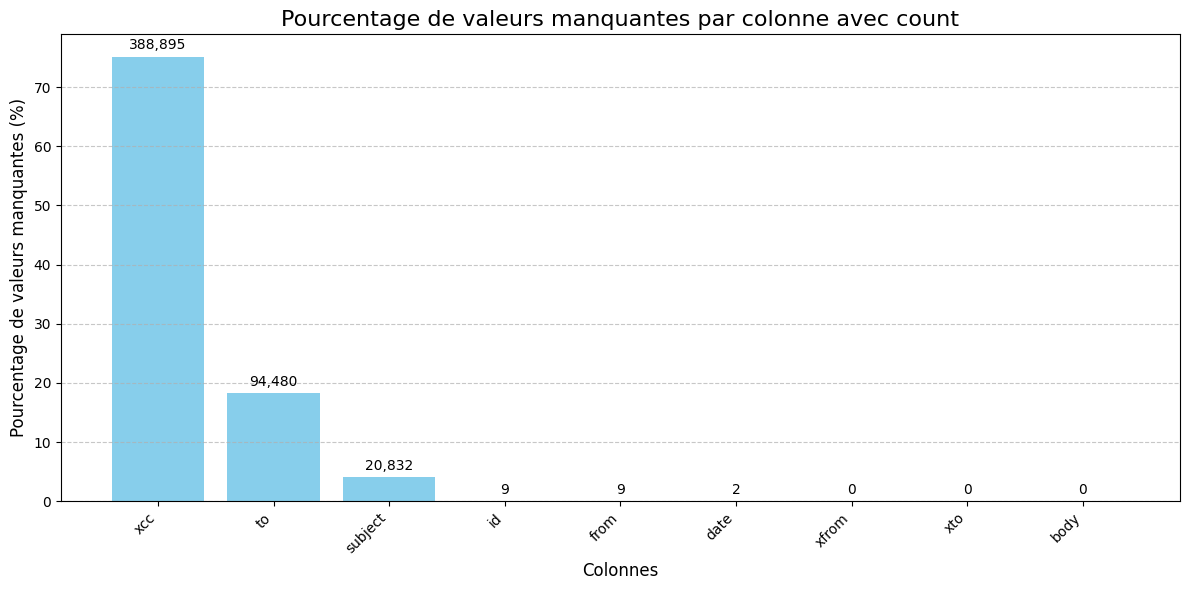

In [5]:
plot_na(df)

In [6]:
df.sort_values(by=['from', 'date'], inplace=True)
df.drop(columns=['id', 'date', 'xto', 'xcc', 'to'], inplace=True)

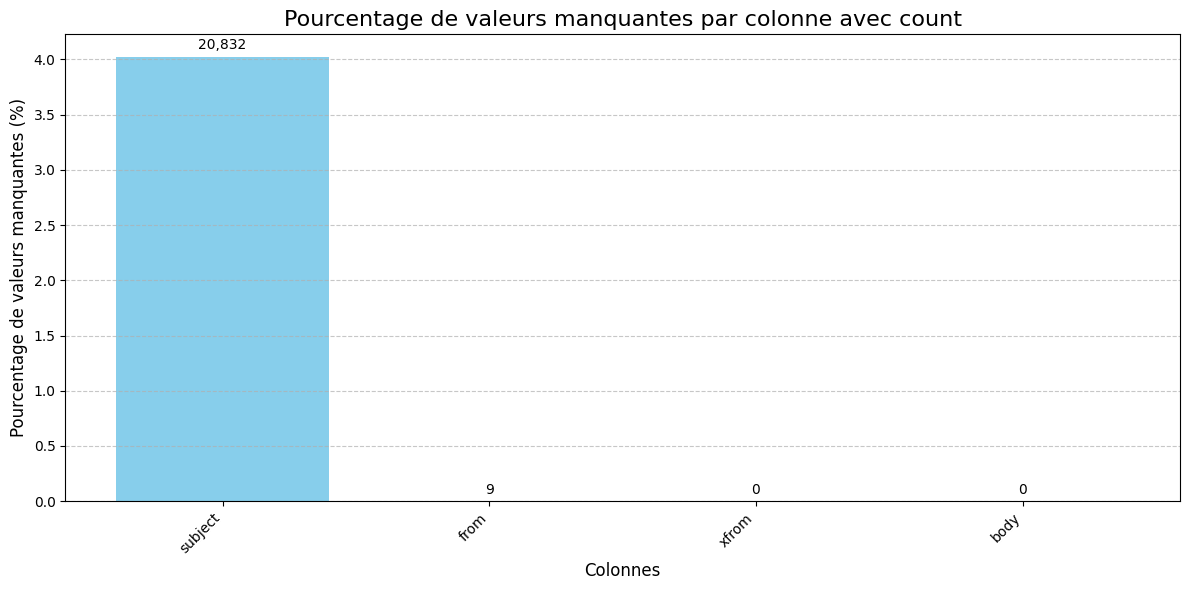

In [7]:
plot_na(df)

In [8]:
df.dropna(inplace=True)
unique_senders = df['from'].unique()
len(unique_senders)

36213

In [9]:
def keep_valid_senders(X) -> Tuple[List[str], List[str]]:
    """Keep only valid senders

    Params:
        X : list of senders
    
    Returns:
        List[str]: list of valid senders
    """
    enron_senders = [sender for sender in X if 'enron' in sender.lower()]
    news_senders = [sender for sender in X if 'news' in sender.lower()]
    no_reply_senders = [sender for sender in X if 'no-reply' in sender.lower()]

    with open('not_enron_correct_mails.pkl', 'rb') as f:
        not_enron_correct_mails = pickle.load(f)
    
    concat_good_senders = enron_senders + not_enron_correct_mails
    concat_good_senders = [sender for sender in concat_good_senders if sender not in news_senders]
    concat_good_senders = [sender for sender in concat_good_senders if sender not in no_reply_senders]
    concat_good_senders = [sender for sender in concat_good_senders if "announcement" not in sender.lower()]
    
    # keep only enron senders that are like nom.prenom@enron.com only with a regex
    matching_re = re.compile(r'^[a-zA-Z]+(?:\.[a-zA-Z]+)?@enron\.com$')
    enron_valid = [sender for sender in concat_good_senders if matching_re.match(sender) is not None]
    return concat_good_senders, enron_valid


In [10]:
concat_good_senders, enron_valid = keep_valid_senders(unique_senders)
len(concat_good_senders), len(enron_valid)

(12708, 5530)

In [11]:
# keep data with enron senders only
X = df[df['from'].isin(enron_valid)]
X.shape

(316500, 4)

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316500 entries, 208382 to 249219
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   from     316500 non-null  object
 1   xfrom    316500 non-null  object
 2   subject  316500 non-null  object
 3   body     316500 non-null  object
dtypes: object(4)
memory usage: 12.1+ MB


# Keep users in Knowledge Graph

In [13]:
graph_users = [
    'sally.beck@enron.com',
    'sarah.davis@enron.com',
    'daryll.fuentes@enron.com',
    'lee.fascetti@enron.com',
    'richard.tomaski@enron.com',
    'vicki.sharp@enron.com',
    'steven.kean@enron.com'
]

X_graph = X[X['from'].isin(graph_users)]

# for each user keep up to 10 mails randomly
X_graph = X_graph.groupby('from').apply(lambda x: x.sample(min(len(x), 10))).reset_index(drop=True)
X_graph.to_csv('emails_graph.csv', index=False)

/tmp/ipykernel_78915/2936140088.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_graph = X_graph.groupby('from').apply(lambda x: x.sample(min(len(x), 10))).reset_index(drop=True)


In [14]:
X_graph["from"].unique()

array(['daryll.fuentes@enron.com', 'lee.fascetti@enron.com',
       'richard.tomaski@enron.com', 'sally.beck@enron.com',
       'sarah.davis@enron.com', 'steven.kean@enron.com',
       'vicki.sharp@enron.com'], dtype=object)

# Continue Analysis

In [15]:
sender_counts = X['from'].value_counts()
print(sender_counts.describe())

count     5530.000000
mean        57.233273
std        413.689052
min          1.000000
25%          2.000000
50%          6.000000
75%         19.000000
max      12320.000000
Name: count, dtype: float64


In [16]:
# save enron senders
with open('valid_enron_senders.pkl', 'wb') as f:
    pickle.dump(enron_valid, f)

In [17]:
max_mails = X['from'].value_counts().max()
# Identifier l'utilisateur correspondant
user_with_max_mails = X['from'].value_counts()[X['from'].value_counts() == max_mails]
print(user_with_max_mails)

from
vince.kaminski@enron.com    12320
Name: count, dtype: int64


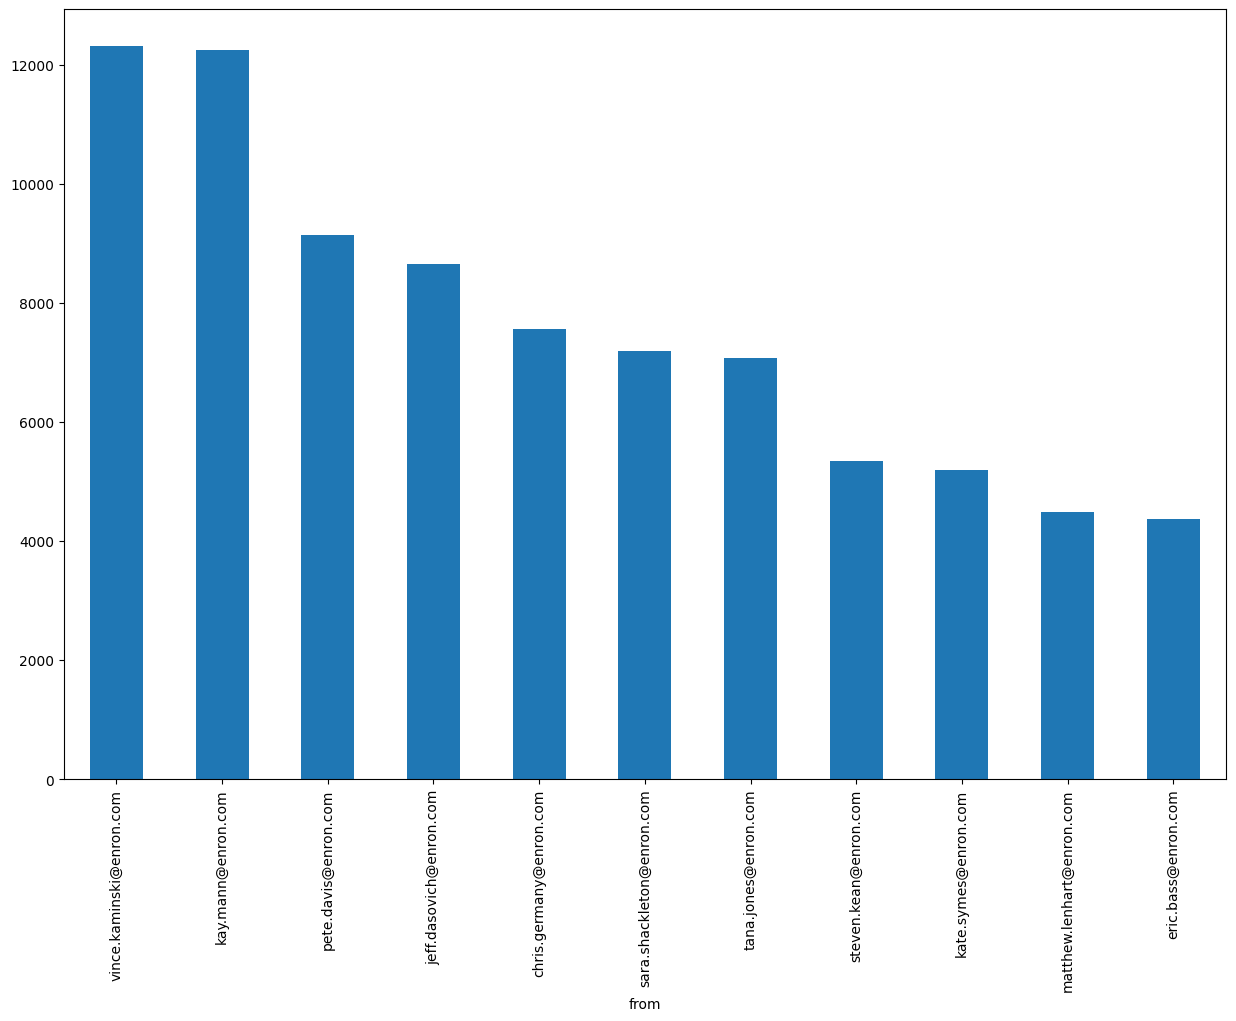

In [18]:
# plot the top 10 mails per senders
plt.figure(figsize=(15, 10))
X['from'].value_counts().head(11).plot(kind='bar')
plt.show()

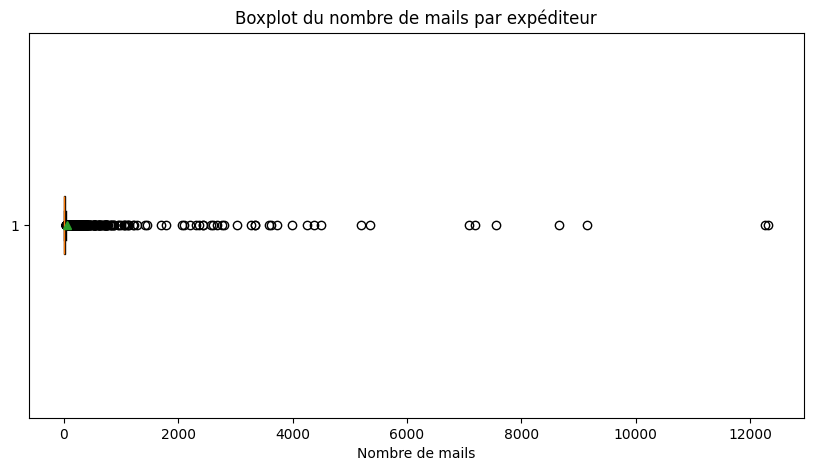

In [19]:
# Compter le nombre d'emails par expéditeur
sender_counts = X['from'].value_counts()
# Créer un boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(sender_counts, vert=False, patch_artist=True, showmeans=True)
plt.title("Boxplot du nombre de mails par expéditeur")
plt.xlabel("Nombre de mails")
plt.show()


In [20]:
sender_counts[sender_counts >=19].count(), sender_counts[sender_counts < 19].count()

(1433, 4097)

In [21]:
# keep only users with more than 10 mails
X = X[X['from'].isin(sender_counts[sender_counts >= 19].index)]

In [22]:
sender_counts = X['from'].value_counts()
print(sender_counts.describe())

count     1433.000000
mean       206.748081
std        794.055825
min         19.000000
25%         28.000000
50%         47.000000
75%        111.000000
max      12320.000000
Name: count, dtype: float64


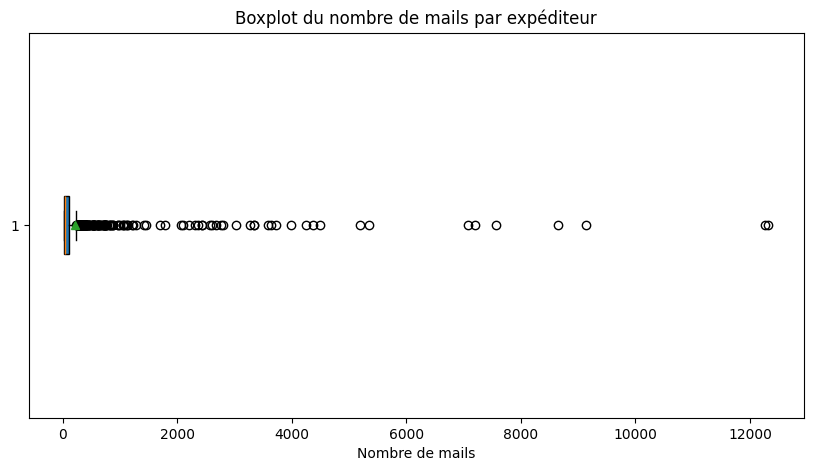

In [23]:
# Compter le nombre d'emails par expéditeur
sender_counts = X['from'].value_counts()

# Créer un boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(sender_counts, vert=False, patch_artist=True, showmeans=True)
plt.title("Boxplot du nombre de mails par expéditeur")
plt.xlabel("Nombre de mails")
plt.show()


In [24]:
# save X
X.to_csv('enron.csv', index=False)

# Analyze Tokens Distribution per Mail/User

In [25]:
X['word_count'] = X['body'].apply(lambda x: len(x.split()))

In [26]:
X

,from,xfrom,subject,body,word_count
348743,Gerald.Nemec@enron.com,jennifer.d.sanders@us.andersen.com@ENRON <IMCE...,RE: Hello!,"Yea, someone should have warned you about the ...",852
348747,Gerald.Nemec@enron.com,jennifer.d.sanders@us.andersen.com@ENRON <IMCE...,RE: Hello!,Wheat of course - blame it on all those years ...,1027
348753,Gerald.Nemec@enron.com,jennifer.d.sanders@us.andersen.com@ENRON <IMCE...,RE: Hello!,"If you worked at the Posse, there's a good cha...",1251
348796,Gerald.Nemec@enron.com,jennifer.d.sanders@us.andersen.com@ENRON <IMCE...,RE: Hello!,Hey Gerald!! The weekend was good. I went to...,385
348799,Gerald.Nemec@enron.com,jennifer.d.sanders@us.andersen.com@ENRON <IMCE...,RE: Hello!,Sounds cool. My mom gave me her guitar a few ...,684
...,...,...,...,...,...
505062,zionette.vincent@enron.com,Zionette Vincent,EB2379 - Greg Whiting (Power Systems),Kelley Ellis 3-3239,3
505821,zionette.vincent@enron.com,Zionette Vincent,EB2379 - Greg Whiting (Power Systems),Kelley Ellis 3-3239,3
503673,zionette.vincent@enron.com,Zionette Vincent,Video Conferencing - Avistar (Brian Woods),Patti Thompson 39106,3
505199,zionette.vincent@enron.com,Zionette Vincent,Video Conferencing - Avistar (Brian Woods),Patti Thompson 39106,3


In [27]:
max_tokens = X['word_count'].max()
user_with_max_tokens = X[X['word_count'] == max_tokens]['from']
print(user_with_max_tokens, max_tokens)


323624    sarah.palmer@enron.com
Name: from, dtype: object 64024


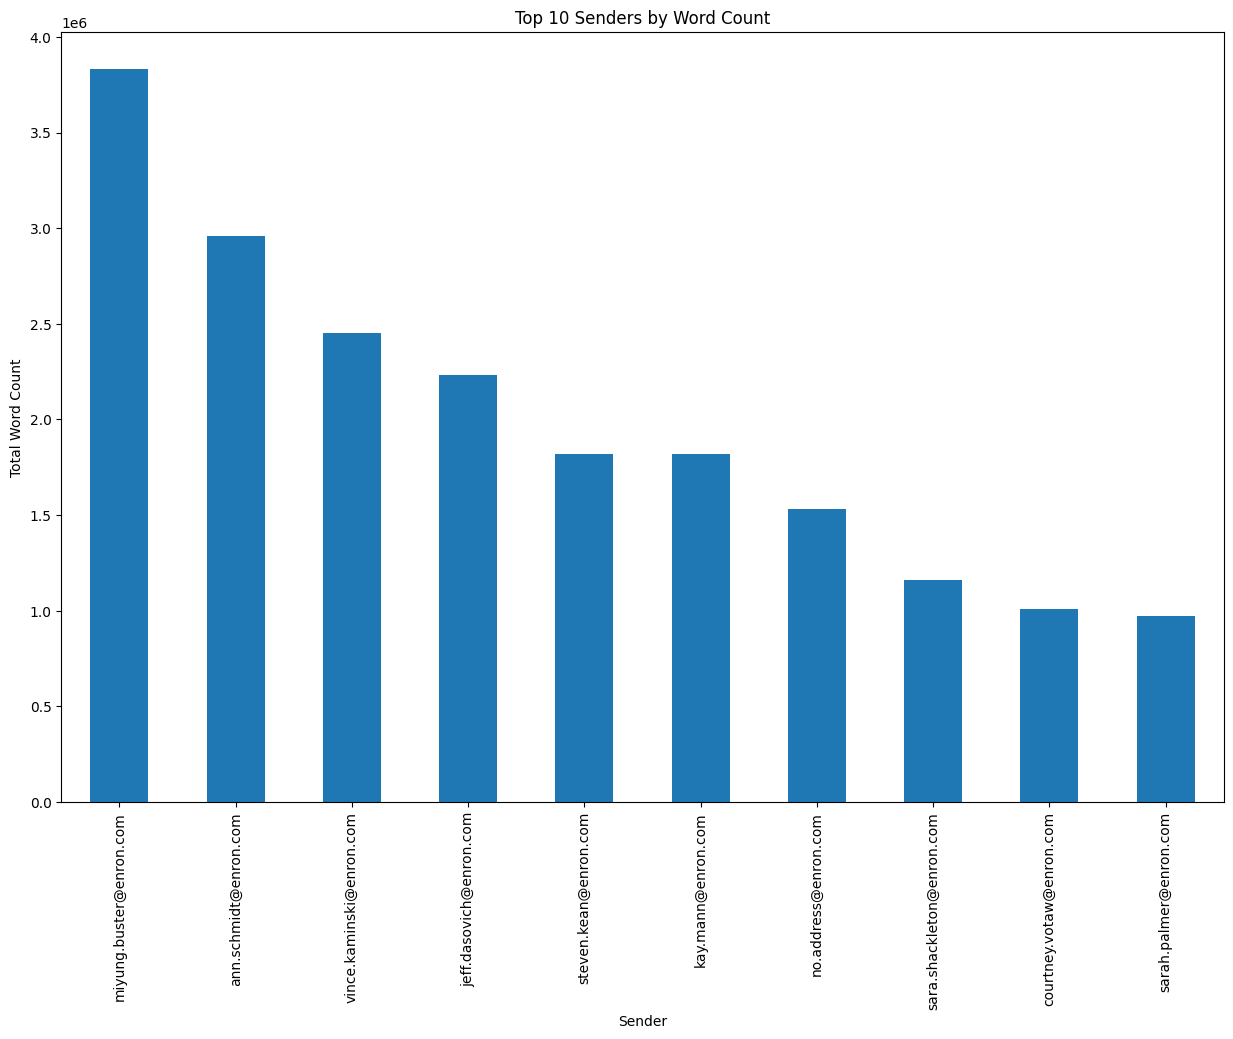

In [28]:
plt.figure(figsize=(15, 10))
X.groupby('from')['word_count'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Senders by Word Count')
plt.xlabel('Sender')
plt.ylabel('Total Word Count')
plt.show()

In [29]:
# average word count per sender
avg_word_count = X.groupby('from')['word_count'].mean()
avg_word_count

from
Gerald.Nemec@enron.com          591.000000
Jeff.Dasovich@enron.com         935.909091
Mary.Hain@enron.com             665.736842
Shirley.Crenshaw@enron.com      395.375000
Tana.Jones@enron.com            120.111111
                                   ...    
yannis.tzamouranis@enron.com    336.619048
yvette.connevey@enron.com       101.369565
zhiyong.wei@enron.com           202.111111
zimin.lu@enron.com              139.290801
zionette.vincent@enron.com       49.705263
Name: word_count, Length: 1433, dtype: float64

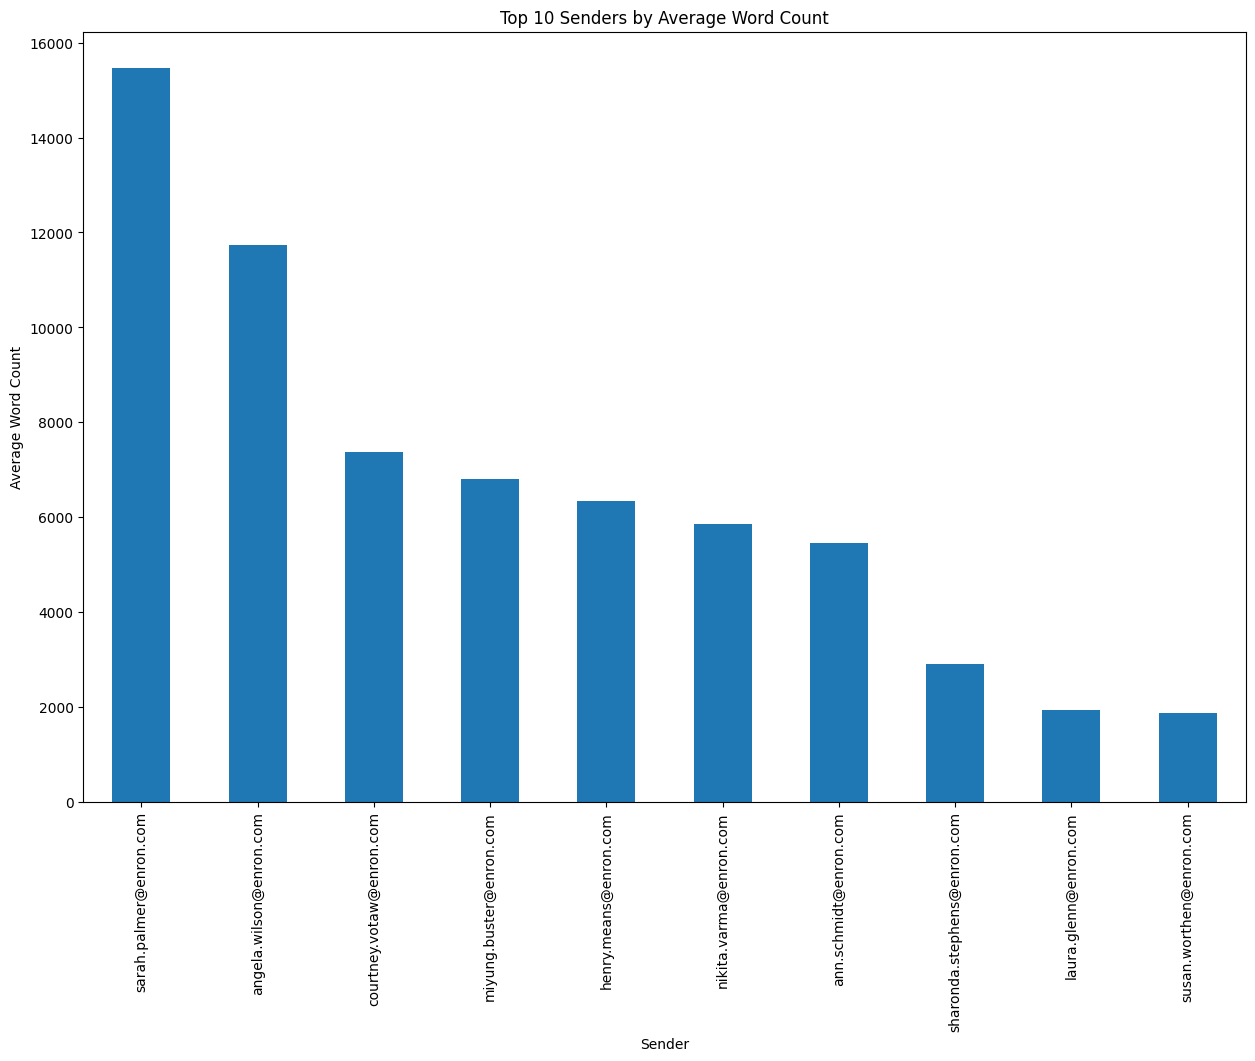

In [30]:
plt.figure(figsize=(15, 10))
avg_word_count.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Senders by Average Word Count')
plt.xlabel('Sender')
plt.ylabel('Average Word Count')
plt.show()

In [31]:
avg_word_count.describe()

count     1433.000000
mean       213.885561
std        648.621263
min          3.714286
25%         78.681159
50%        130.750000
75%        217.024390
max      15461.936508
Name: word_count, dtype: float64

In [32]:
sender_counts = X['from'].value_counts()
print(sender_counts.describe())

count     1433.000000
mean       206.748081
std        794.055825
min         19.000000
25%         28.000000
50%         47.000000
75%        111.000000
max      12320.000000
Name: count, dtype: float64


In [33]:
# keep only users with less than 6k words (future work : contexte size of llama3 70B)
X = X[X['from'].isin(avg_word_count[avg_word_count < 6000].index)]

In [34]:
# keep the top 10 senders with the highest average word count less than 6k
X = X[X['from'].isin(avg_word_count.sort_values(ascending=False).head(16).index)]

In [35]:
X

,from,xfrom,subject,body,word_count
58995,ann.schmidt@enron.com,Ann M Schmidt,Enron Mentions,Democrats Prepare to Duel Bush Over Energy Pri...,8597
73941,ann.schmidt@enron.com,Ann M Schmidt,Enron Mentions,Democrats Prepare to Duel Bush Over Energy Pri...,8597
229218,ann.schmidt@enron.com,Ann M Schmidt,Enron Mentions,Democrats Prepare to Duel Bush Over Energy Pri...,8597
233720,ann.schmidt@enron.com,Ann M Schmidt,Enron Mentions,Democrats Prepare to Duel Bush Over Energy Pri...,8597
242810,ann.schmidt@enron.com,Ann M Schmidt,Enron Mentions,Democrats Prepare to Duel Bush Over Energy Pri...,8597
...,...,...,...,...,...
230203,susan.worthen@enron.com,Susan Worthen,EHS Weekly Report Ending 03/08/01,ADMINISTRATIVE/ GENERAL\n\n\nUS EPA - Mike Te...,2176
234703,susan.worthen@enron.com,Susan Worthen,EHS Weekly Report Ending 03/08/01,ADMINISTRATIVE/ GENERAL\n\n\nUS EPA - Mike Te...,2176
241822,susan.worthen@enron.com,Susan Worthen,EHS Weekly Report Ending 03/08/01,ADMINISTRATIVE/ GENERAL\n\n\nUS EPA - Mike Te...,2176
246347,susan.worthen@enron.com,Susan Worthen,EHS Weekly Report Ending 03/08/01,ADMINISTRATIVE/ GENERAL\n\n\nUS EPA - Mike Te...,2176


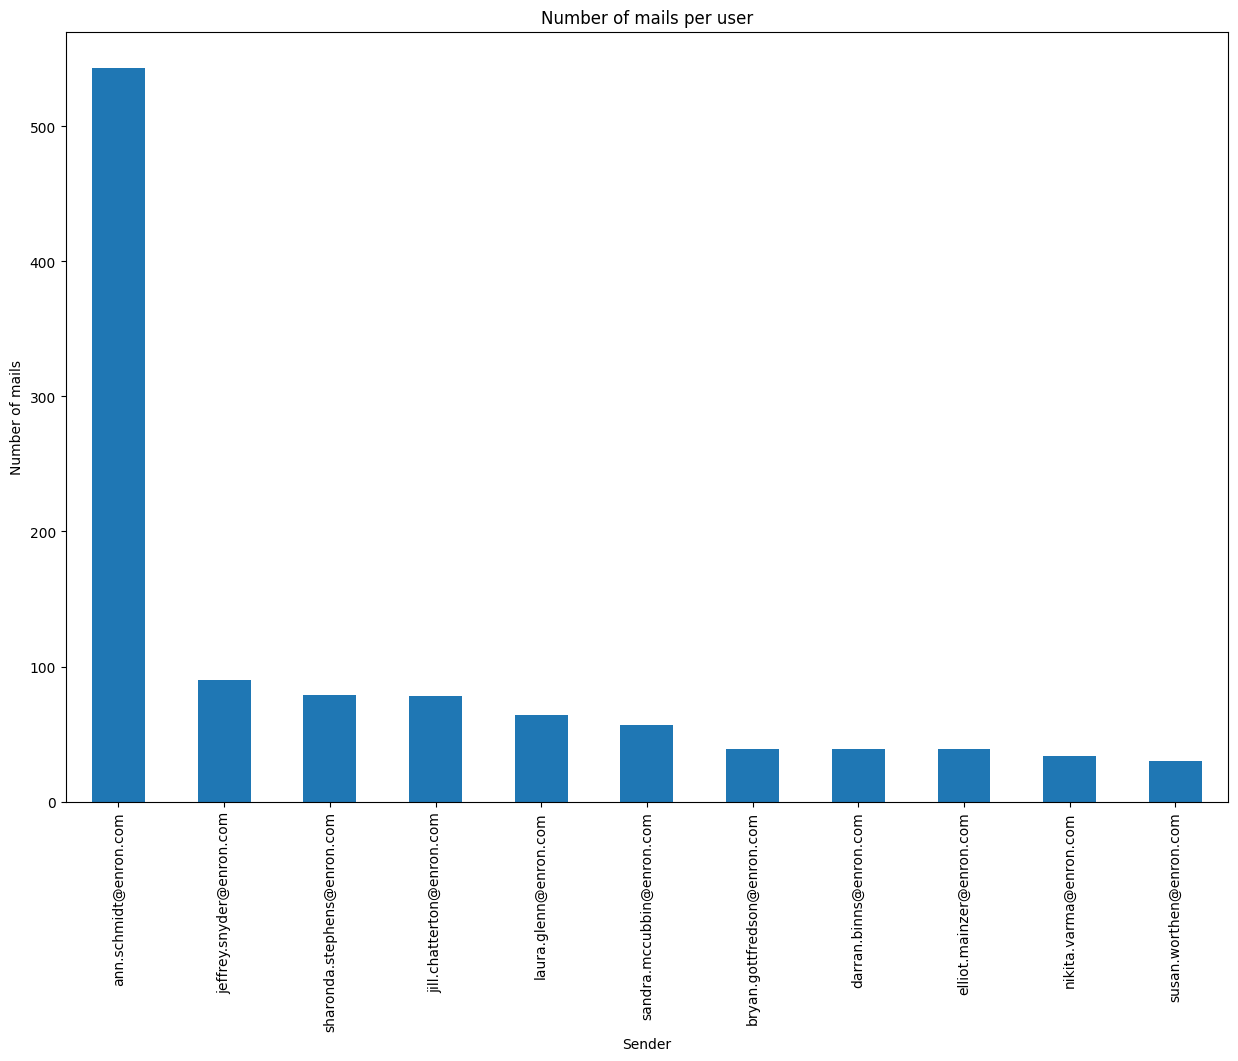

In [36]:
# mails per user
plt.figure(figsize=(15, 10))
X['from'].value_counts().plot(kind='bar')
plt.title('Number of mails per user')
plt.xlabel('Sender')
plt.ylabel('Number of mails')
plt.show()